In [1]:
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Flatten, GlobalAveragePooling1D
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv').sort_values(['series_id', 'measurement_number'])

### Join train features with labels

In [3]:
train = pd.merge(train, labels, how='inner').sort_values(['series_id', 'measurement_number'])
print(train.shape)
display(train.head())
display(train.describe().T)

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


### Turn data into series

In [4]:
def series_to_supervised(data, features, window=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data[features].shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in features]
    # Current timestep (t=0)
    cols.append(data)
    names += [(col) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [5]:
window = 29
features = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'series_id']
use_cols = features + ['surface']
# Train
train_series = series_to_supervised(train[use_cols], features, window=window)
train_series.dropna(inplace=True)        
train_series = train_series[(train_series['series_id'] == train_series['series_id(t-%s)' % window])]
display(train_series.head())

# Test
test_series = series_to_supervised(test[features], features, window=window)
test_series.fillna(test_series.mean(), inplace=True)

# Backwards inputation
for index, row in test_series.iterrows():
    for i in range(1, window+1):
        if row['series_id'] != row['series_id(t-%s)' % i]:
            for feature in features:
                if feature != 'series_id':
                    test_series.at[index, '%s(t-%s)' % (feature, i)] = row[feature]
display(test_series.head())

,angular_velocity_X(t-29),angular_velocity_Y(t-29),angular_velocity_Z(t-29),linear_acceleration_X(t-29),linear_acceleration_Y(t-29),linear_acceleration_Z(t-29),series_id(t-29),angular_velocity_X(t-28),angular_velocity_Y(t-28),angular_velocity_Z(t-28),linear_acceleration_X(t-28),linear_acceleration_Y(t-28),linear_acceleration_Z(t-28),series_id(t-28),angular_velocity_X(t-27),angular_velocity_Y(t-27),angular_velocity_Z(t-27),linear_acceleration_X(t-27),linear_acceleration_Y(t-27),linear_acceleration_Z(t-27),series_id(t-27),angular_velocity_X(t-26),angular_velocity_Y(t-26),angular_velocity_Z(t-26),linear_acceleration_X(t-26),linear_acceleration_Y(t-26),linear_acceleration_Z(t-26),series_id(t-26),angular_velocity_X(t-25),angular_velocity_Y(t-25),angular_velocity_Z(t-25),linear_acceleration_X(t-25),linear_acceleration_Y(t-25),linear_acceleration_Z(t-25),series_id(t-25),angular_velocity_X(t-24),angular_velocity_Y(t-24),angular_velocity_Z(t-24),linear_acceleration_X(t-24),linear_acceleration_Y(t-24),...,linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),series_id(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),series_id(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id,surface
29,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.0,0.067851,0.029939,0.003385,0.33995,1.50640,-9.4128,0.0,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.099300,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,...,0.06985,4.8894,-8.5877,0.0,-0.049055,-0.022872,0.012317,-0.68261,4.2634,-8.6405,0.0,-0.052707,-0.008394,-0.005122,-0.10727,4.0335,-9.1909,0.0,-0.063422,0.037429,0.008045,-0.249780,4.4821,-9.4874,0.0,-0.029260,0.004637,0.007209,-1.313000,4.2696,-9.5157,0.0,-0.024414,-0.021222,0.018677,-0.156840,5.1946,-9.7347,0,fine_concrete
30,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.0,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,...,-0.68261,4.2634,-8.6405,0.0,-0.052707,-0.008394,-0.005122,-0.10727,4.0335,-9.1909,0.0,-0.063422,0.037429,0.008045,-0.24978,4.4821,-9.4874,0.0,-0.029260,0.004637,0.007209,-1.313000,4.2696,-9.5157,0.0,-0.024414,-0.021222,0.018677,-0.156840,5.1946,-9.7347,0.0,-0.028238,0.016226,0.009824,-0.972630,4.8610,-9.8303,0,fine_concrete
31,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.0,0.056218,0.038162,-0.022931,-0.12160,0.075417,...,-0.10727,4.0335,-9.1909,0.0,-0.063422,0.037429,0.008045,-0.24978,4.4821,-9.4874,0.0,-0.029260,0.004637,0.007209,-1.31300,4.2696,-9.5157,0.0,-0.024414,-0.021222,0.018677,-0.156840,5.1946,-9.7347,0.0,-0.028238,0.016226,0.009824,-0.972630,4.8610,-9.8303,0.0,0.002065,0.045389,0.000449,-0.058101,3.4756,-11.1700,0,fine_concrete
32,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,0.0,0.005135,0.007652,0.005245,

,angular_velocity_X(t-29),angular_velocity_Y(t-29),angular_velocity_Z(t-29),linear_acceleration_X(t-29),linear_acceleration_Y(t-29),linear_acceleration_Z(t-29),series_id(t-29),angular_velocity_X(t-28),angular_velocity_Y(t-28),angular_velocity_Z(t-28),linear_acceleration_X(t-28),linear_acceleration_Y(t-28),linear_acceleration_Z(t-28),series_id(t-28),angular_velocity_X(t-27),angular_velocity_Y(t-27),angular_velocity_Z(t-27),linear_acceleration_X(t-27),linear_acceleration_Y(t-27),linear_acceleration_Z(t-27),series_id(t-27),angular_velocity_X(t-26),angular_velocity_Y(t-26),angular_velocity_Z(t-26),linear_acceleration_X(t-26),linear_acceleration_Y(t-26),linear_acceleration_Z(t-26),series_id(t-26),angular_velocity_X(t-25),angular_velocity_Y(t-25),angular_velocity_Z(t-25),linear_acceleration_X(t-25),linear_acceleration_Y(t-25),linear_acceleration_Z(t-25),series_id(t-25),angular_velocity_X(t-24),angular_velocity_Y(t-24),angular_velocity_Z(t-24),linear_acceleration_X(t-24),linear_acceleration_Y(t-24),...,angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),series_id(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),series_id(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id
0,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.386742,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.390647,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.394553,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.398459,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.402364,-0.006524,-0.001071,-0.027390,0.10043,4.2061,...,-0.027390,0.10043,4.2061,-5.5439,1907.480474,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.484379,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.488284,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.49219,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.496095,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0
1,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.386742,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.390647,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.394553,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.398459,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.402364,-0.113960,0.083987,-0.060590,-0.70889,3.9905,...,-0.060590,-0.70889,3.9905,-8.0273,1907.480474,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.484379,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.488284,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.49219,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0
2,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.386742,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.390647,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.394553,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.398459,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.402364,-0.080518,0.114860,-0.037177,1.45710,2.2828,...,-0.037177,1.45710,2.2828,-11.2990,1907.480474,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.484379,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.488284,-0.006524,-0.001071,-0.027390,0.10043,4.2061,

### Pre process the labels

In [6]:
n_labels =  train_series['surface'].nunique()
labels_names = train_series['surface'].unique()
le = LabelEncoder()
train_series['surface'] = le.fit_transform(train_series['surface'].values)

### Train/validation split

In [7]:
train_splited = []
val_splited = []
gp_surface = train.groupby(['surface', 'series_id'], as_index=False).count()[['surface', 'series_id']]
for surface in gp_surface['surface'].unique():
    df = gp_surface[gp_surface['surface'] == surface]
    tra, val = train_test_split(df, test_size=0.2, random_state=0)
    train_splited += list(tra['series_id'].values)
    val_splited += list(val['series_id'].values)
    
train_splited = pd.DataFrame(train_splited, columns=['series_id'])
val_splited = pd.DataFrame(val_splited, columns=['series_id'])

In [8]:
X_train = train_splited.merge(train_series)
X_val = val_splited.merge(train_series)

Y_train = X_train['surface']
Y_train = to_categorical(Y_train)
X_train.drop('surface', axis=1, inplace=True)
X_train = X_train

Y_val = X_val['surface']
Y_val = to_categorical(Y_val)
X_val.drop('surface', axis=1, inplace=True)
X_val = X_val

series_cols = list(X_train.filter(regex="series_id\(t-"))
X_train.drop(series_cols, axis=1, inplace=True)
X_val.drop(series_cols, axis=1, inplace=True)
test_series.drop(series_cols, axis=1, inplace=True)

print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())

Train shape (301356, 181)
Validation shape (75834, 181)


,series_id,angular_velocity_X(t-29),angular_velocity_Y(t-29),angular_velocity_Z(t-29),linear_acceleration_X(t-29),linear_acceleration_Y(t-29),linear_acceleration_Z(t-29),angular_velocity_X(t-28),angular_velocity_Y(t-28),angular_velocity_Z(t-28),linear_acceleration_X(t-28),linear_acceleration_Y(t-28),linear_acceleration_Z(t-28),angular_velocity_X(t-27),angular_velocity_Y(t-27),angular_velocity_Z(t-27),linear_acceleration_X(t-27),linear_acceleration_Y(t-27),linear_acceleration_Z(t-27),angular_velocity_X(t-26),angular_velocity_Y(t-26),angular_velocity_Z(t-26),linear_acceleration_X(t-26),linear_acceleration_Y(t-26),linear_acceleration_Z(t-26),angular_velocity_X(t-25),angular_velocity_Y(t-25),angular_velocity_Z(t-25),linear_acceleration_X(t-25),linear_acceleration_Y(t-25),linear_acceleration_Z(t-25),angular_velocity_X(t-24),angular_velocity_Y(t-24),angular_velocity_Z(t-24),linear_acceleration_X(t-24),linear_acceleration_Y(t-24),linear_acceleration_Z(t-24),angular_velocity_X(t-23),angular_velocity_Y(t-23),angular_velocity_Z(t-23),...,angular_velocity_Z(t-6),linear_acceleration_X(t-6),linear_acceleration_Y(t-6),linear_acceleration_Z(t-6),angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,1769,0.028959,-0.011703,0.026238,0.032400,4.1378,-8.8985,0.014238,-0.015342,0.030203,0.422020,3.7190,-9.1178,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.035360,-0.032865,0.037684,0.16020,3.9802,-9.1033,0.028209,-0.006577,0.039904,0.09113,3.9570,-9.1022,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786,0.034825,-0.020897,0.042671,...,0.035709,0.78230,1.5729,-8.9791,0.006729,-0.023648,0.024883,1.15730,1.9671,-8.9271,-0.002974,-0.019664,0.031419,0.69680,1.9254,-9.1081,-0.004981,-0.022006,0.020894,0.436500,1.9512,-9.3698,-0.003322,-0.023238,0.033730,0.348330,1.7676,-9.6960,0.006430,-0.027683,0.031206,-0.285490,1.6090,-9.8846,-0.003640,-0.011659,0.032447,0.485100,2.0116,-9.6940
1,1769,0.014238,-0.015342,0.030203,0.422020,3.7190,-9.1178,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.028209,-0.006577,0.039904,0.09113,3.9570,-9.1022,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355,0.060540,-0.014815,0.045493,...,0.024883,1.15730,1.9671,-8.9271,-0.002974,-0.019664,0.031419,0.69680,1.9254,-9.1081,-0.004981,-0.022006,0.020894,0.43650,1.9512,-9.3698,-0.003322,-0.023238,0.033730,0.348330,1.7676,-9.6960,0.006430,-0.027683,0.031206,-0.285490,1.6090,-9.8846,-0.003640,-0.011659,0.032447,0.485100,2.0116,-9.6940,-0.016694,0.000341,0.041115,-0.040275,2.2459,-9.2973
2,1769,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355,0.060540,-0.014815,0.045493,-0.53125,3.1171,-9.6271,0.065362,-0.005506,0.040376,...,0.031419,0.69680,1.9254,-9.1081,-0.004981,-0.022006,0.020894,0.43650,1.9512,-9.3698,-0.003322,-0.023238,0.033730,0.34833,1.7676,-9.6960,0.006430,-0.027683,0.031206,-0.285490,1.6090,-9.8846,-0.003640,-0.011659,0.032447,0.

### Feature engineering

In [9]:
# def feat_eng(df):
#     df['totl_anglr_vel'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z'])** 0.5
#     df['totl_linr_acc'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z'])**0.5
# #     df['totl_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z'])**0.5
#     df['acc_vs_vel'] = df['totl_linr_acc'] / df['totl_anglr_vel']
#     for i in range(1, (window+1)):
#         df['totl_anglr_vel(t-%s)' % i] = (df['angular_velocity_X(t-%s)' % i]**2 + df['angular_velocity_Y(t-%s)' % i]**2 + df['angular_velocity_Z(t-%s)' % i])** 0.5
#         df['totl_linr_acc(t-%s)' % i] = (df['linear_acceleration_X(t-%s)' % i]**2 + df['linear_acceleration_Y(t-%s)' % i]**2 + df['linear_acceleration_Z(t-%s)' % i])**0.5
#     #     df['totl_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z'])**0.5
#         df['acc_vs_vel(t-%s)' % i] = df['totl_linr_acc(t-%s)' % i] / df['totl_anglr_vel(t-%s)' % i]

# feat_eng(X_train)
# feat_eng(X_val)
# feat_eng(test_series)

# X_train.fillna(0, inplace=True)
# X_val.fillna(0, inplace=True)
# test_series.fillna(0, inplace=True)

In [10]:
# def quaternion_to_euler(x, y, z, w):
#     import math
#     t0 = +2.0 * (w * x + y * z)
#     t1 = +1.0 - 2.0 * (x * x + y * y)
#     X = math.atan2(t0, t1)

#     t2 = +2.0 * (w * y - z * x)
#     t2 = +1.0 if t2 > +1.0 else t2
#     t2 = -1.0 if t2 < -1.0 else t2
#     Y = math.asin(t2)

#     t3 = +2.0 * (w * z + x * y)
#     t4 = +1.0 - 2.0 * (y * y + z * z)
#     Z = math.atan2(t3, t4)

#     return X, Y, Z


# def perform_feature_engineering(df):
#     x, y, z, w = df['orientation_X'].tolist(), df['orientation_Y'].tolist(), df['orientation_Z'].tolist(), df['orientation_W'].tolist()
#     nx, ny, nz = [], [], []
#     for i in range(len(x)):
#         xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
#         nx.append(xx)
#         ny.append(yy)
#         nz.append(zz)
    
#     df['euler_x'] = nx
#     df['euler_y'] = ny
#     df['euler_z'] = nz
    
#     df['total_angle'] = np.sqrt(np.square(df['euler_x']) + np.square(df['euler_y']) + np.square(df['euler_z']))
#     df['angle_vs_acc'] = df['total_angle'] / df['totl_linr_acc']
#     df['angle_vs_vel'] = df['total_angle'] / df['totl_anglr_vel']
    
# perform_feature_engineering(X_train)
# perform_feature_engineering(X_val)
# perform_feature_engineering(test_series)

In [11]:
# def mean_change_of_abs_change(x):
#         return np.mean(np.diff(np.abs(np.diff(x))))

# def mean_abs_change(x):
#     return np.mean(np.abs(np.diff(x)))

# def summarize_cols(df):
#     cols = df.columns
#     for col in cols:
#         if col in ['row_id', 'series_id', 'measurement_number', 'group_id', 'surface']:
#             continue
#         df[col + '_mean'] = df.groupby(['series_id'])[col].mean()
#         df[col + '_min'] = df.groupby(['series_id'])[col].min()
#         df[col + '_max'] = df.groupby(['series_id'])[col].max()
#         df[col + '_std'] = df.groupby(['series_id'])[col].std()
#         df[col + '_mad'] = df.groupby(['series_id'])[col].mad()
#         df[col + '_med'] = df.groupby(['series_id'])[col].median()
#         df[col + '_skew'] = df.groupby(['series_id'])[col].skew()
#         df[col + '_max_to_min'] = df[col + '_max'] / df[col + '_min']
# #         df[col + '_mean_abs_change'] = df.groupby('series_id')[col].apply(mean_abs_change)
# #         df[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
# #         df[col + '_abs_max'] = df.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
# #         df[col + '_abs_min'] = df.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))
# #         df[col + '_abs_mean'] = df.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(x)))
# #         df[col + '_abs_std'] = df.groupby('series_id')[col].apply(lambda x: np.std(np.abs(x)))

# summarize_cols(X_train)
# summarize_cols(X_val)
# summarize_cols(test_series)

In [12]:
series_cols = list(X_train.filter(regex='series_id'))
X_train.drop(series_cols, axis=1, inplace=True)
X_val.drop(series_cols, axis=1, inplace=True)
test_series.drop(series_cols, axis=1, inplace=True)

In [13]:
X_train.fillna(0, inplace = True)
X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_val.fillna(0, inplace = True)
X_val.replace(-np.inf, 0, inplace = True)
X_val.replace(np.inf, 0, inplace = True)
test_series.fillna(0, inplace = True)
test_series.replace(-np.inf, 0, inplace = True)
test_series.replace(np.inf, 0, inplace = True)

In [14]:
features = list(X_train.columns)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.describe())

Train shape (301356, 180)
Validation shape (75834, 180)


,angular_velocity_X(t-29),angular_velocity_Y(t-29),angular_velocity_Z(t-29),linear_acceleration_X(t-29),linear_acceleration_Y(t-29),linear_acceleration_Z(t-29),angular_velocity_X(t-28),angular_velocity_Y(t-28),angular_velocity_Z(t-28),linear_acceleration_X(t-28),linear_acceleration_Y(t-28),linear_acceleration_Z(t-28),angular_velocity_X(t-27),angular_velocity_Y(t-27),angular_velocity_Z(t-27),linear_acceleration_X(t-27),linear_acceleration_Y(t-27),linear_acceleration_Z(t-27),angular_velocity_X(t-26),angular_velocity_Y(t-26),angular_velocity_Z(t-26),linear_acceleration_X(t-26),linear_acceleration_Y(t-26),linear_acceleration_Z(t-26),angular_velocity_X(t-25),angular_velocity_Y(t-25),angular_velocity_Z(t-25),linear_acceleration_X(t-25),linear_acceleration_Y(t-25),linear_acceleration_Z(t-25),angular_velocity_X(t-24),angular_velocity_Y(t-24),angular_velocity_Z(t-24),linear_acceleration_X(t-24),linear_acceleration_Y(t-24),linear_acceleration_Z(t-24),angular_velocity_X(t-23),angular_velocity_Y(t-23),angular_velocity_Z(t-23),linear_acceleration_X(t-23),...,angular_velocity_Z(t-6),linear_acceleration_X(t-6),linear_acceleration_Y(t-6),linear_acceleration_Z(t-6),angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,...,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000,301356.000000
mean,0.000239,0.008404,-0.019648,0.128809,2.890969,-9.364601,0.000269,0.008406,-0.019661,0.128739,2.890833,-9.364200,0.000265,0.008408,-0.019676,0.129145,2.890953,-9.363537,0.000251,0.008411,-0.019688,0.128998,2.890462,-9.363500,0.000243,0.008408,-0.019706,0.128879,2.890096,-9.363954,0.000254,0.008409,-0.019713,0.128732,2.889596,-9.364709,0.000274,0.008402,-0.019721,0.127820,...,-0.019485,0.126627,2.886091,-9.364906,0.000286,0.008451,-0.019488,0.126487,2.886118,-9.363829,0.000242,0.008470,-0.019493,0.126437,2.886501,-9.363136,0.000184,0.008496,-0.019501,0.126356,2.886436,-9.363700,0.000165,0.008501,-0.019505,0.126270,2.886337,-9.365084,0.000197,0.008492,-0.019508,0.126198,2.885928,-9.366569,0.000257,0.008500,-0.019513,0.126257,2.885066,-9.367219
std,0.116854,0.088067,0.226675,1.875611,2.101406,2.819935,0

### Scale the data

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_series)

In [16]:
X_train_series = X_train.reshape(X_train.shape[0], (window+1), (X_train.shape[1] // (window+1)))
X_val_series = X_val.reshape(X_val.shape[0], (window+1), (X_val.shape[1] // (window+1)))
X_test_series = X_test.reshape(X_test.shape[0], (window+1), (X_test.shape[1] // (window+1)))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_val_series.shape)
print('Test set shape', X_test_series.shape)
# subsequences = 2
# timesteps = X_train.shape[1]//subsequences
# X_train_series = X_train.reshape(X_train.shape[0], subsequences, (window+1), ((X_train.shape[1] // (window+1))//subsequences))
# X_val_series = X_val.reshape(X_val.shape[0], subsequences, (window+1), ((X_val.shape[1] // (window+1))//subsequences))
# X_test_series = X_test.reshape(X_test.shape[0], subsequences, (window+1), ((X_test.shape[1] // (window+1))//subsequences))
# print('Train set shape', X_train_series.shape)
# print('Validation set shape', X_val_series.shape)
# print('Test set shape', X_test_series.shape)

Train set shape (301356, 30, 6)
Validation set shape (75834, 30, 6)
Test set shape (488448, 30, 6)


### Model

In [17]:
epochs = 100
batch = 128
lr = 0.0001
optimizer = optimizers.Adam(lr=lr)

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
def step_decay(epoch):
    initial_lrate = lr
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

In [19]:
model = Sequential()
model.add(Conv1D(30, 5, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model.add(Conv1D(30, 5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(30, 5, activation='relu'))
model.add(Conv1D(30, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_labels, activation="softmax"))
model.summary()

lrate = LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# callbacks = [lrate, es]
callbacks = [es]
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 26, 30)            930       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 30)            4530      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 30)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 30)             4530      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3, 30)             4530      
_________________________________________________________________
flatten_1 (Flatten)          (None, 90)                0         
___________________________

In [20]:
history = model.fit(X_train_series, Y_train, validation_data=(X_val_series, Y_val), epochs=epochs, callbacks=callbacks, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 301356 samples, validate on 75834 samples
Epoch 1/100
 - 71s - loss: 1.9679 - val_loss: 1.7265
Epoch 2/100
 - 66s - loss: 1.7416 - val_loss: 1.6067
Epoch 3/100
 - 66s - loss: 1.6744 - val_loss: 1.5720
Epoch 4/100
 - 65s - loss: 1.6424 - val_loss: 1.5319
Epoch 5/100
 - 65s - loss: 1.6197 - val_loss: 1.5414
Epoch 6/100
 - 65s - loss: 1.6031 - val_loss: 1.5429
Epoch 7/100
 - 66s - loss: 1.5865 - val_loss: 1.5192
Epoch 8/100
 - 65s - loss: 1.5739 - val_loss: 1.5020
Epoch 9/100
 - 65s - loss: 1.5637 - val_loss: 1.4916
Epoch 10/100
 - 65s - loss: 1.5542 - val_loss: 1.4971
Epoch 11/100
 - 65s - loss: 1.5444 - val_loss: 1.5060
Epoch 12/100
 - 64s - loss: 1.5362 - val_loss: 1.5103
Epoch 13/100
 - 64s - loss: 1.5259 - val_loss: 1.4814
Epoch 14/100
 - 64s - loss: 1.5205 - val_loss: 1.4943
Epoch 15/100
 - 64s - loss: 1.5130 - val_loss: 1.4637
Epoch 16/100
 - 64s - loss: 1.5076 - val_loss: 1.4712
Epoch 17/100
 - 64s - loss: 1.5033 - val_loss:

#### Model loss plot

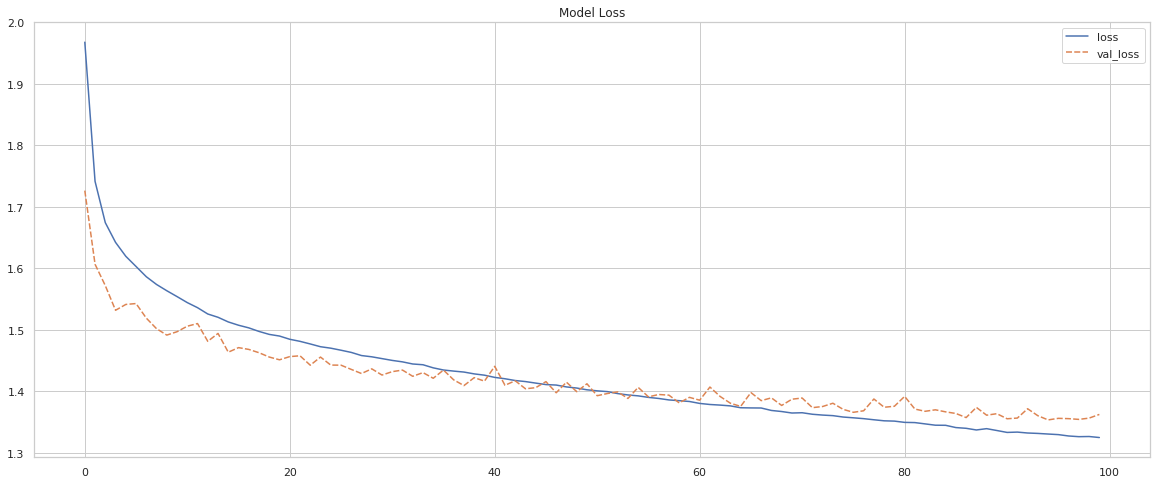

In [21]:
history_pd = pd.DataFrame.from_dict({'loss': history.history['loss'], 
                                     'val_loss': history.history['val_loss']})
plt.figure(figsize=(20, 8))
ax = plt.axes()
ax.set_title('Model Loss')
sns.lineplot(data=history_pd)
plt.show()

#### Model evaluation

In [22]:
train_pred = model.predict_classes(X_train_series)
val_pred = model.predict_classes(X_val_series)
Y_train_max = np.argmax(Y_train, axis=1)
Y_val_max = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train_max, train_pred))
print('Validation accuracy', accuracy_score(Y_val_max, val_pred))

Train accuracy 0.5263641672971502
Validation accuracy 0.5024395389930638


#### Model confusion matrix

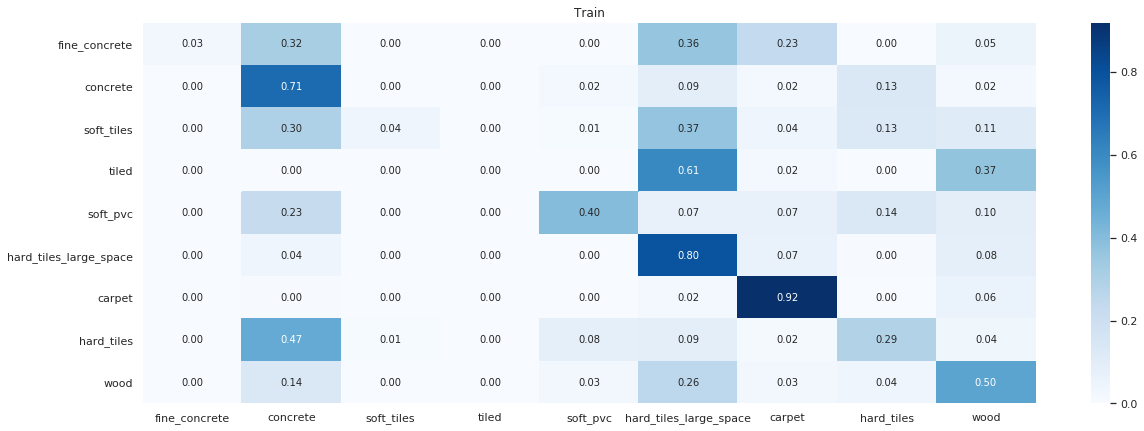

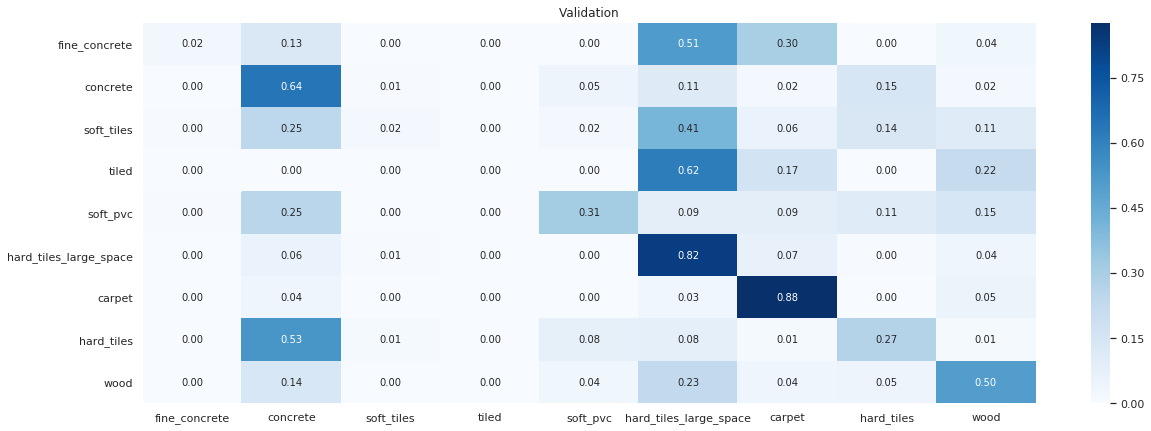

In [23]:
cnf_matrix = confusion_matrix(Y_train_max, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [24]:
predictions = model.predict_classes(X_test_series)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)

,series_id,surface
0,0,tiled
1,1,soft_pvc
2,2,concrete
3,3,soft_tiles
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,hard_tiles_large_space
8,8,soft_tiles
9,9,wood
